Once darkCNN has been run this can be run to look at some results.

In [ ]:
#Defaults from darkCNN


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import darkCNN
import numpy as np
from matplotlib import pyplot as plt

Get the training and test samples 

In [18]:
trainingSet, testSet = darkCNN.getData( nChannels=1, allDataFile='exampleCNN.pkl')

Number of Samples in the Test Set is 240


Plot some examples of the dataset

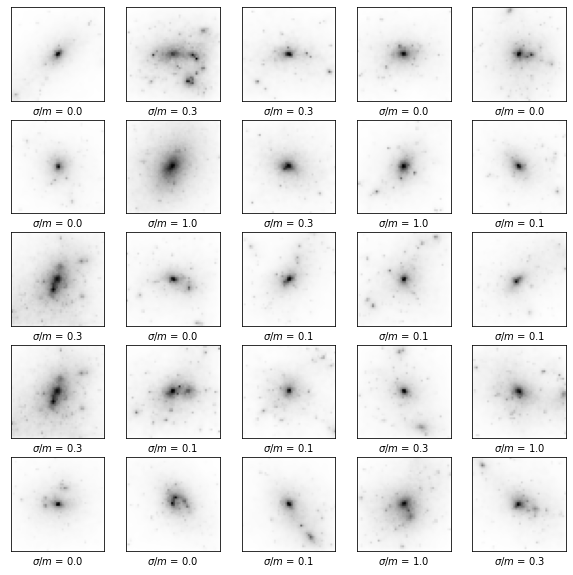

In [22]:
nClasses = len(np.unique(trainingSet['label']))
inputShape = trainingSet['images'].shape[1:]
plt.figure(figsize=(10,10))
for j in range(25):
    i = np.random.randint(0, trainingSet['images'].shape[0])
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainingSet['images'][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
    plt.xlabel(r"$\sigma/m$ = %s" % trainingSet['label'][i][0])
plt.show()

In [7]:
augmentedTrain, augmentedLabels = darkCNN.augmentData( trainingSet['images'], trainingSet['label'])

Number of Samples in the Test Set is 240


NameError: name 'nChannels' is not defined

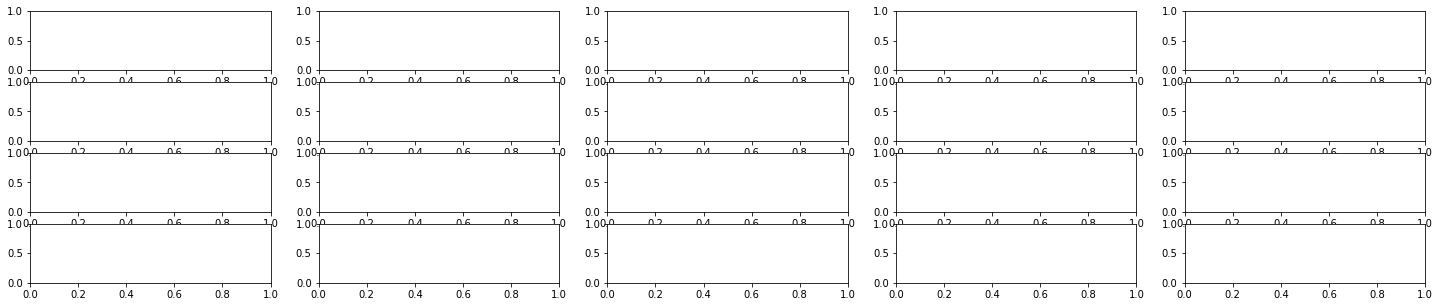

In [25]:
fig, ax = plt.subplots(4,5, figsize=(25,5))

for iMonte in range(2):
    
    trainingSet, testSet = darkCNN.getData( allDataFile='exampleCNN.pkl', \
                                           indexFileRoot='pickles/testIndexes_%i' % (iMonte))
    
    modelName = "pickles/simpleModel_%i_channel_noAtt_dropout_%0.1f_testSplit_%0.3f_%i.h5" % \
            (nChannels, dropout, testTrainSplit,iMonte)
        
    mertensModel = models.load_model(modelName)

    prediction = np.argmax(mertensModel.predict(testSet['images']),axis=1)

    for axis, i in enumerate(np.unique(test_labels)):
        ax[axis, iMonte].hist(prediction[test_labels[:,0]==i], bins=np.linspace(-0.5,3.5,8), density=True)
        ax[axis, iMonte].set_xlim(-1,4)
        acc = np.where(prediction[test_labels[:,0]==i]==i)[0].shape[0]/prediction[test_labels[:,0]==i].shape[0]
        ax[axis, iMonte].text(0.6, 0.8, "Class %i=%0.2f" % (i,acc), transform=ax[axis,iMonte].transAxes, fontsize=15)
        if i != len(ax)-1:
            ax[axis, iMonte].set_xticklabels([])
            ax[axis, iMonte].set_yticklabels([])
    
fig.subplots_adjust(hspace=0)

In [10]:
epoch, accuracy, loss, val_accuracy, val_loss = \
    np.loadtxt( "pickles/mertensModel_dropout_0.2_testSplit_0.1_1.csv", delimiter=',',skiprows=1,unpack=True)

OSError: pickles/mertensModel_dropout_0.2_testSplit_0.1_1.csv not found.

In [ ]:
plt.plot(epoch,loss)
plt.plot(epoch,val_loss)
plt.plot(epoch,accuracy)
plt.plot(epoch,val_accuracy)
plt.ylim(0,1)

In [11]:
prediction = mertensModel.predict(test_images)

In [ ]:
allPrediction  = np.argmax( prediction, axis=1)

In [ ]:
fig, ax = plt.subplots(4,1)
cross = np.array([0., 0.1, 0.3, 1.0])
labels = np.arange(4)+1
for axis, i in enumerate(cross):
    
    
    ax[axis].hist(allPrediction[test_labels[:,0]==axis], bins=np.linspace(-0.5,3.5,5))
    ax[axis].set_xlim(-1,5.)
    print(len(allPrediction[test_labels[:,0]==axis][allPrediction[test_labels[:,0]==axis] == axis]))

In [ ]:
#Add a dense layer for regression to the model
inputLayerFromCNN = Input(shape=mertensModel.output.shape)
regressorLayer = layers.BatchNormalization()(inputLayerFromCNN)
regressorLayer = layers.Dense(128)(regressorLayer)
regressorLayer = layers.BatchNormalization()(regressorLayer)
regressorLayer = layers.Dense(1)(regressorLayer)
finalModel = Model(inputLayerFromCNN, regressorLayer, name='regressorLayer')
finalModel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001, centered=True),
              loss=['mean_squared_error'])

In [ ]:
trainPredictions = mertensModel.predict(train_images)

In [ ]:
shiftedPredictions = trainPredictions - np.min(trainPredictions, axis=1)[:,np.newaxis]
normedTrainPredictions = shiftedPredictions / np.sum(shiftedPredictions, axis=1)[:,np.newaxis]

In [ ]:
train_labels[ train_labels==0] = 0
train_labels[ train_labels==1] = 0.1
train_labels[ train_labels==2] = 0.3
train_labels[ train_labels==3] = 1.


In [ ]:
test_labels[ test_labels==0] = 0
test_labels[ test_labels==1] = 0.1
test_labels[ test_labels==2] = 0.3
test_labels[ test_labels==3] = 1.

In [ ]:
inceptionHistory = finalModel.fit(trainPredictions[:,np.newaxis,:], 
          train_labels,  
          epochs=100, validation_data=(prediction[:,np.newaxis,:], test_labels ))

In [ ]:
plt.plot(inceptionHistory.history['loss'])
plt.plot(inceptionHistory.history['val_loss'])

In [ ]:
regression = finalModel.predict(prediction[:,np.newaxis,:] )

In [ ]:
fig, ax = plt.subplots(4,1)
cross = np.array([0., 0.1, 0.3, 1.0])
labels = np.arange(4)+1
for axis, i in enumerate(cross):
    y, x = np.histogram(regression[test_labels[:,0]==i,0,0], bins=np.linspace(-1.5,5.5,100), density=True)
    xc = (x[1:] + x[:-1])/2.
    ax[axis].plot( xc, y)
    ax[axis].plot( [i,i],[0,1])
    ax[axis].set_xlim(-1,2.)


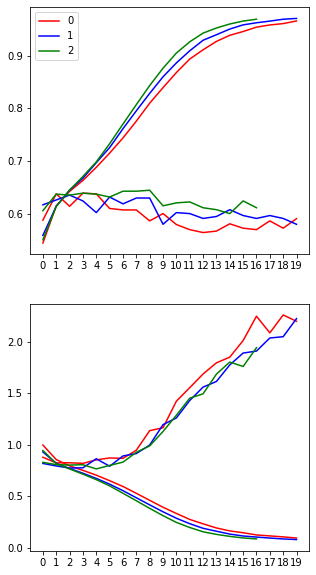

In [12]:
color = ['r','b','g','c','orange']
fig, axarr = plt.subplots( 2,1, figsize=(5,10))
for i in range(3):
    csvLogger = "pickles/augmentedTrain_%i_channel_noAtt_dropout_0.2_testSplit_0.150_0.csv" % (i+1)
    csvFile = np.loadtxt( csvLogger, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
    
   # plt.plot(csvFile['epoch'], csvFile['val_loss'], color=color[i])
    axarr[0].plot(csvFile['epoch'], csvFile['val_accuracy'], color=color[i], label=i)
    axarr[0].plot(csvFile['epoch'], csvFile['accuracy'], color=color[i])
    axarr[1].plot(csvFile['epoch'], csvFile['val_loss'], color=color[i])
    axarr[1].plot(csvFile['epoch'], csvFile['loss'], color=color[i])
axarr[0].legend()
